In [1]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [27]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import time
from torchsummary import summary
from sklearn.metrics import accuracy_score

import numpy as np
import matplotlib.pyplot as plt
import os
import copy
from copy import deepcopy

from PIL import Image

In [2]:
# image_transforms = { 
#     'train': transforms.Compose([
#         transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
#         transforms.RandomRotation(degrees=15),
#         transforms.RandomHorizontalFlip(),
#         transforms.CenterCrop(size=224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406],
#                              [0.229, 0.224, 0.225])w
#     ]),
#     'valid': transforms.Compose([
#         transforms.Resize(size=256),
#         transforms.CenterCrop(size=224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406],
#                              [0.229, 0.224, 0.225])
#     ]),
#     'test': transforms.Compose([
#         transforms.Resize(size=256),
#         transforms.CenterCrop(size=224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406],
#                              [0.229, 0.224, 0.225])
#     ])
# }


image_transforms = {
    'train': transforms.Compose([
        # Add more data augmentation techniques
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [3]:
# Load the Data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Set train and valid directory paths

dataset = '/Users/k.saidarshanreddy/Downloads/CLASSIFICATION-OF-PNEUMONIA-USING-PRETRAINED-ALEXNET-MODEL-FROM-CHEST-X-RAY-IMAGES-DURING-COVID-19-main/Datasets/dataset_for_fourway_classification'

train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'valid')

# Batch size
bs = 32
num_epochs=10

# Number of classes
num_classes = len(os.listdir(valid_directory))  #10#2#257
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)

6
{0: 'Bacterial Pneumonia', 1: 'COVID 19', 2: 'NORMAL', 3: 'Tuberculosis', 4: 'Viral Pneumonia'}


In [4]:
train_data_size, valid_data_size


(19559, 922)

In [5]:
alexnet = models.alexnet(pretrained=True)
alexnet

/Users/k.saidarshanreddy/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/k.saidarshanreddy/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [6]:
# Freeze model parameters
for param in alexnet.parameters():
    param.requires_grad = False

In [7]:
# Change the final layer of AlexNet Model for Transfer Learning
alexnet.classifier[6] = nn.Linear(4096, num_classes)
alexnet.classifier.add_module("7", nn.LogSoftmax(dim = 1))


# Move the model to the selected device
alexnet = alexnet.to(device)

In [8]:
summary(alexnet, (3,224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [9]:
# Define Optimizer and Loss Function
loss_func = nn.NLLLoss()
optimizer = optim.Adam(alexnet.parameters(), lr=0.001)
# optimizer

# Define a learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [12]:
def train_and_validate(model, loss_func, optimizer, scheduler, epochs=num_epochs):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    y_true = []  # List to store actual labels             new---------------
    y_pred = []  # List to store predicted labels          new---------------


    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_func(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            # Append actual and predicted labels to y_true and y_pred
            y_true.extend(labels.cpu().numpy().tolist())
            y_pred.extend(predictions.cpu().numpy().tolist())
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_func(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        #torch.save(model, dataset+'model'+str(epoch)+'.pt')
            
    return model, history

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_epochs = 10
trained_model, history = train_and_validate(alexnet, loss_func, optimizer, num_epochs)

torch.save(history, dataset+'_history.pt')

Epoch: 1/10
Epoch : 001, Training: Loss: 0.6413, Accuracy: 74.8198%, 
		Validation : Loss : 1.1034, Accuracy: 44.4685%, Time: 485.9727s
Epoch: 2/10
Epoch : 002, Training: Loss: 0.5629, Accuracy: 77.9897%, 
		Validation : Loss : 0.8715, Accuracy: 60.0868%, Time: 503.5001s
Epoch: 3/10
Epoch : 003, Training: Loss: 0.5601, Accuracy: 78.2606%, 
		Validation : Loss : 1.2521, Accuracy: 33.2972%, Time: 575.3125s
Epoch: 4/10
Epoch : 004, Training: Loss: 0.5470, Accuracy: 78.4345%, 
		Validation : Loss : 1.1546, Accuracy: 40.7809%, Time: 541.4034s
Epoch: 5/10
Epoch : 005, Training: Loss: 0.5442, Accuracy: 78.8793%, 
		Validation : Loss : 0.9358, Accuracy: 50.2169%, Time: 529.7722s
Epoch: 6/10
Epoch : 006, Training: Loss: 0.5568, Accuracy: 78.2044%, 
		Validation : Loss : 0.8638, Accuracy: 61.4967%, Time: 504.0987s
Epoch: 7/10
Epoch : 007, Training: Loss: 0.5481, Accuracy: 78.5418%, 
		Validation : Loss : 1.2297, Accuracy: 40.5640%, Time: 486.7699s
Epoch: 8/10
Epoch : 008, Training: Loss: 0.5652,

In [35]:
# Specify the file path where you want to save the model
model_save_path = 'my_trained_model.pth'

# Save the trained model
torch.save(trained_model, model_save_path)

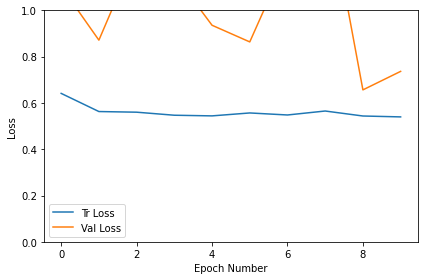

In [26]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig(dataset+'_loss_curve.png')
plt.tight_layout()
plt.show()

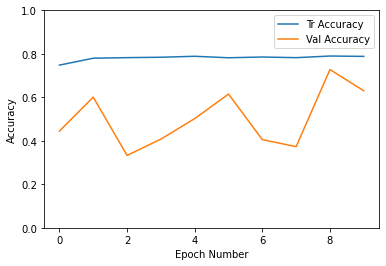

In [15]:
plt.plot(history[:,2:4])

plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

In [31]:
accuracy = accuracy_score(valid, test)

# Print the accuracy
print(f'Overall Accuracy: {accuracy * 100:.2f}%')


NameError: name 'valid' is not defined

In [16]:
def predict(model, test_image_name):
    '''
    Function to predict the class of a single test image
    Parameters
        :param model: Model to test
        :param test_image_name: Test image

    '''
    img = Image.open(test_image_name).convert("RGB")
    
    width,height = img.size
    
    pixels = img.load()
 
    
    for py in range(height):
        for px in range(width):
            r,g,b = img.getpixel((px,py))
            newr = r
            newg = g
            newb = b
            pixels[px,py] = (newr,newg,newb)
         
            
    transform = image_transforms['test']
    
    
    test_image_tensor = transform(img)

    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(2, dim=1)
        for i in range(1):
            print("Predcition", ":", idx_to_class[topclass.numpy()[0][i]], ", Score: ", topk.numpy()[0][i])
    plt.imshow(img)

Predcition : COVID 19 , Score:  0.8633754


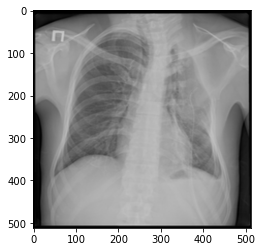

In [17]:

predict(trained_model, '/Users/k.saidarshanreddy/Downloads/CLASSIFICATION-OF-PNEUMONIA-USING-PRETRAINED-ALEXNET-MODEL-FROM-CHEST-X-RAY-IMAGES-DURING-COVID-19-main/Datasets/Tuberculosis-110.png')


Predcition : NORMAL , Score:  0.92193216


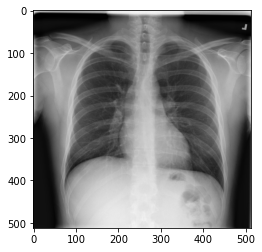

In [18]:

predict(trained_model, '/Users/k.saidarshanreddy/Downloads/CLASSIFICATION-OF-PNEUMONIA-USING-PRETRAINED-ALEXNET-MODEL-FROM-CHEST-X-RAY-IMAGES-DURING-COVID-19-main/Datasets/Normal-10.png')


Predcition : Tuberculosis , Score:  0.9991937


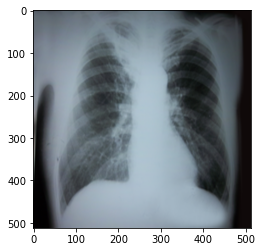

In [19]:
predict(trained_model, '/Users/k.saidarshanreddy/Downloads/CLASSIFICATION-OF-PNEUMONIA-USING-PRETRAINED-ALEXNET-MODEL-FROM-CHEST-X-RAY-IMAGES-DURING-COVID-19-main/Datasets/dataset_for_fourway_classification/valid/Tuberculosis/Tuberculosis-698.png')

Predcition : Tuberculosis , Score:  0.9974444


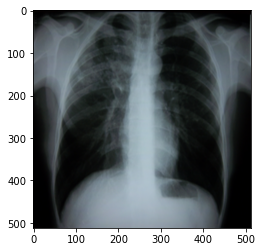

In [20]:
predict(trained_model, '/Users/k.saidarshanreddy/Downloads/CLASSIFICATION-OF-PNEUMONIA-USING-PRETRAINED-ALEXNET-MODEL-FROM-CHEST-X-RAY-IMAGES-DURING-COVID-19-main/Datasets/dataset_for_fourway_classification/valid/Tuberculosis/Tuberculosis-690.png')

Predcition : Viral Pneumonia , Score:  0.57756406


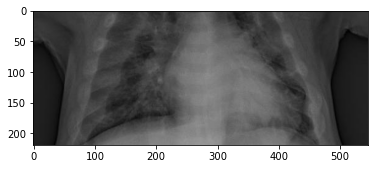

In [22]:
predict(trained_model, '/Users/k.saidarshanreddy/Downloads/CLASSIFICATION-OF-PNEUMONIA-USING-PRETRAINED-ALEXNET-MODEL-FROM-CHEST-X-RAY-IMAGES-DURING-COVID-19-main/Datasets/dataset_for_fourway_classification/valid/Viral Pneumonia/person276_virus_569.jpeg')

Predcition : Bacterial Pneumonia , Score:  0.87437606


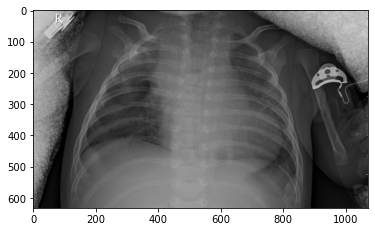

In [23]:
predict(trained_model, '/Users/k.saidarshanreddy/Downloads/CLASSIFICATION-OF-PNEUMONIA-USING-PRETRAINED-ALEXNET-MODEL-FROM-CHEST-X-RAY-IMAGES-DURING-COVID-19-main/Datasets/dataset_for_fourway_classification/valid/Bacterial Pneumonia/person26_bacteria_132.jpeg')

In [45]:
from torch.utils.data import DataLoader


model = torch.load('/Users/k.saidarshanreddy/Downloads/final year project/my_trained_model.pth')

# Set the model to evaluation mode
model.eval()

# Initialize empty lists for y_true and y_pred
y_true = []
y_pred = []

# Create a DataLoader for your validation dataset
validation_loader = DataLoader(data['valid'], batch_size=bs, shuffle=False)

# Assuming 'validation_dataset' is your validation dataset

# Iterate through the validation dataset and collect actual and predicted labels
for inputs, labels in validation_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Forward pass - compute outputs on input data using the model
    outputs = model(inputs)

    # Calculate predictions
    _, predicted = torch.max(outputs, 1)

    # Append actual and predicted labels to y_true and y_pred
    y_true.extend(labels.cpu().numpy().tolist())
    y_pred.extend(predicted.cpu().numpy().tolist())

In [46]:
accuracy = accuracy_score(y_true, y_pred)

In [47]:
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 63.02%


In [48]:
from sklearn.metrics import confusion_matrix

#Get the confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

print(cf_matrix)

[[ 55   0   2   0   7]
 [  0  70  31   0   0]
 [  0   2  70   0   0]
 [  0   0   0  22   0]
 [259   3  37   0 364]]


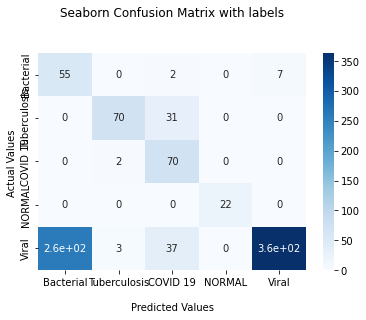

In [49]:
import seaborn as sns
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Bacterial', 'Tuberculosis', 'COVID 19','NORMAL','Viral'])
ax.yaxis.set_ticklabels(['Bacterial', 'Tuberculosis', 'COVID 19','NORMAL','Viral'])
## Display the visualization of the Confusion Matrix.
plt.show()